# Data Science Professionals Job Market and Salaries in US and UK

### Required packages:

In [ ]:
!python -m pip install kaggle==1.6.12

In [ ]:
!pip install --target=/workspace ucimlrepo numpy==1.24.3

In [ ]:
!pip install kaggle

In [ ]:
!pip install kagglehub

In [ ]:
!pip install beautifulsoup4 requests

In [ ]:
!pip install selenium

In [ ]:
!pip install webdriver-manager

In [2]:
import pandas as pd
import requests
import zipfile
import io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time

## 1. Gathering data

### **1.1.** Problem Statement

In this report we would like to analyse major characteristics of US and UK job markets for data science professionals in Mid-senior level, specifically:
- how many open positions are available in both countries based on the available data sources;
- what are the Average Salary, Standard deviation, Mode, Minimum and Maximum Salaries of UK and US;
- how different Average Salaries are for Mid-senior level Data Science professionals between mentioned countries during the observed period.

In order to perform the analysis we will use below data:
1) Data Science Job postings on LinkedIn;
2) Salaries of Data Science professionals

### **1.2.** Gathering datasets
**General Note** For the purposes of this report two methods were used: API and HTML. 

Download of CSV (although less complex) was not chosen as a method in order to test various methods in our developments.

#### **Dataset 1 Data Science Job Postings**

Type: *CSV in ZIP file*

Method: *The data was gathered by accessing API via Kaggle.com*

Dataset variables:

 *   *job_link: LinkedIn link*
 *   *last_processed_time: data extraction time*
 *   *last_status*
 *   *got_summary*
 *   *got_ner*
 *   *is_being_worked*
 *   *job_title: Job Title as posted*
 *   *company: Recruiting company name*
 *   *job_location: Location of the job*
 *   *first_seen: when originally posted*
 *   *search_city: City*
 *   *search_country: Country*
 *   *search_position: Position*
 *   *job_level*
 *   *job_type: Job Type either Onsite, Remote or Hybdrid*

**Description**: 
This dataset has information about job postings in Data Science field as of January 2024, where we can analyze data about Job title, location, Job levels and more. This dataset is useful in understanding and analyzing demand for data science professionals, including seniority level. The dataset was extracted using API method.

In [3]:
#Data Science Job Postings data gathering and loading
original_get = requests.get
requests.get = lambda *args, **kwargs: original_get(*args, verify=False, **kwargs)

# Download the dataset as a zip file
dataset_name = "asaniczka/data-science-job-postings-and-skills"
url = f'https://www.kaggle.com/api/v1/datasets/download/{dataset_name}'
response = requests.get(url)

# Restore the original requests.get method
requests.get = original_get

# Check if the request was successful
if response.status_code == 200:
    # Load the zip file into a pandas DataFrame
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # Check if 'job_postings.csv' exists in the zip file
        if 'job_postings.csv' in z.namelist():
            with z.open('job_postings.csv') as f:
                df = pd.read_csv(f)
            print("job_postings.csv loaded successfully.")
        else:
            print("'job_postings.csv' not found in the zip file.")
else:
    print(f"Failed to download dataset: {response.status_code}")

# Display the DataFrame (optional)
print(df.info())

C:\Users\gcfoj\AppData\Local\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.kaggle.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
C:\Users\gcfoj\AppData\Local\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


job_postings.csv loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12217 entries, 0 to 12216
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_link             12217 non-null  object
 1   last_processed_time  12217 non-null  object
 2   last_status          12217 non-null  object
 3   got_summary          12217 non-null  object
 4   got_ner              12217 non-null  object
 5   is_being_worked      12217 non-null  object
 6   job_title            12217 non-null  object
 7   company              12217 non-null  object
 8   job_location         12216 non-null  object
 9   first_seen           12217 non-null  object
 10  search_city          12217 non-null  object
 11  search_country       12217 non-null  object
 12  search_position      12217 non-null  object
 13  job_level            12217 non-null  object
 14  job_type             12217 non-null  object
dtypes: object(15)
m

#### Dataset 2 Salaries of Data Science professionals

Type: *CSV in ZIP file*

Method: *The data was gathered using HTML from Kaggle*
IMPORTANT: Microsoft Edge has to be installed

Dataset variables:
*   *Job Title: Job Title of DS jobs*
*   *Employment Type: e.g. Full-time*
*   *Experience Level: Senior, Mid, Executive*
*   *Expertise Level: Expert, Intermediate, Director*
*   *Salary*
*   *Salary Currency*
*   *Company Location: Country*
*   *Salary in USD*
*   *Employee Residence: Country*
*   *Company Size*

**Description**: This dataset contains information about Salary, Experience level, Job title, Country and other information of Data Science Professionals between 2020-2024 years in selected countries.

**Limitation**: This data contains significant amount of data, but for the purposes of this report in order to ensure the speed performance of data load we limited data to 600 entries (or 12 scrolls of the webpage). This limit can be extended to a broader scope in the relevant parameters below.

In [4]:
#Salaries of Data Science professionals data gathering and loading

# Set up the Selenium WebDriver for Microsoft Edge
options = webdriver.EdgeOptions()
options.use_chromium = True  
driver = webdriver.Edge(options=options)

url = 'https://www.kaggle.com/datasets/iamsouravbanerjee/data-science-salaries-2023/data'

# Open the URL
driver.get(url)

# Wait for the page to fully load
wait = WebDriverWait(driver, 10)
wait.until(EC.presence_of_all_elements_located((By.CLASS_NAME, 'sc-hwHwzU')))

# Initialize a list to hold the data rows
data_rows = []

# Simulate scroll events to load additional content
for scroll_count in range(12):  # PLEASE ADJUST HERE in case if more data (scrolls) are needed, 12 scrolls give 600 entries
    # Scroll down using JavaScript
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

    # Wait for the dynamically loaded content to appear
    wait.until(EC.presence_of_all_elements_located((By.CLASS_NAME, 'sc-hwHwzU')))
    
    # Collect the rows after each scroll
    rows = driver.find_elements(By.CLASS_NAME, 'sc-hwHwzU')

    # Loop through each row and extract the relevant data
    for row in rows:
        divs = row.find_elements(By.TAG_NAME, 'div')
        data_row = [div.text for div in divs]
        if len(data_row) == 10:
            data_rows.append(data_row)

# Define the column names
columns = [
    "Job Title",
    "Employment Type",
    "Experience Level",
    "Expertise Level",
    "Salary",
    "Salary Currency",
    "Company Location",
    "Salary in USD",
    "Employee Residence",
    "Company Size"
]

# Create a DataFrame
df_2 = pd.DataFrame(data_rows, columns=columns)

# Close the browser
driver.quit()

Data storing step

In [5]:
#storing the raw data in the local data store
df.to_csv('raw_data1.csv', index=False)
df_2.to_csv('raw_data2.csv', index=False)

## 2. Data Assessment

We have started Data Assessment phase from the general inspection of data below to understand the fields and afterwards performed separate analysis on specific issues identified.

In [6]:
# General inspection of data
df.head()

,job_link,last_processed_time,last_status,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type
0,https://www.linkedin.com/jobs/view/senior-mach...,2024-01-21 08:08:48.031964+00,Finished NER,t,t,f,Senior Machine Learning Engineer,Jobs for Humanity,"New Haven, CT",2024-01-14,East Haven,United States,Agricultural-Research Engineer,Mid senior,Onsite
1,https://www.linkedin.com/jobs/view/principal-s...,2024-01-20 04:02:12.331406+00,Finished NER,t,t,f,"Principal Software Engineer, ML Accelerators",Aurora,"San Francisco, CA",2024-01-14,El Cerrito,United States,Set-Key Driver,Mid senior,Onsite
2,https://www.linkedin.com/jobs/view/senior-etl-...,2024-01-21 08:08:31.941595+00,Finished NER,t,t,f,Senior ETL Data Warehouse Specialist,Adame Services LLC,"New York, NY",2024-01-14,Middletown,United States,Technical Support Specialist,Associate,Onsite
3,https://www.linkedin.com/jobs/view/senior-data...,2024-01-20 15:30:55.796572+00,Finished NER,t,t,f,Senior Data Warehouse Developer / Architect,Morph Enterprise,"Harrisburg, PA",2024-01-12,Lebanon,United States,Architect,Mid senior,Onsite
4,https://www.linkedin.com/jobs/view/lead-data-e...,2024-01-21 08:08:58.312124+00,Finished NER,t,t,f,Lead Data Engineer,Dice,"Plano, TX",2024-01-14,McKinney,United States,Maintenance Data Analyst,Mid senior,Onsite


In [7]:
df.tail()

,job_link,last_processed_time,last_status,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type
12212,https://uk.linkedin.com/jobs/view/data-reporti...,2024-01-21 07:11:22.099082+00,Finished NER,t,t,f,"Data Reporting Manager, FOOTBALL ASSOCIATION",Guardian Jobs,"Wembley, England, United Kingdom",2024-01-16,High Wycombe,United Kingdom,Manager Forms Analysis,Mid senior,Onsite
12213,https://www.linkedin.com/jobs/view/corporate-a...,2024-01-19 15:10:41.177008+00,Finished NER,t,t,f,Corporate AML Alert Investigation Specialist,"Glacier Bancorp, Inc.","Kalispell, MT",2024-01-14,Montana,United States,Teller,Mid senior,Onsite
12214,https://www.linkedin.com/jobs/view/senior-data...,2024-01-20 15:20:19.036168+00,Finished NER,t,t,f,Senior Data Scientist,Highnote,"San Francisco, CA",2024-01-16,San Rafael,United States,Mathematician,Mid senior,Onsite
12215,https://www.linkedin.com/jobs/view/senior-data...,2024-01-19 23:25:28.107523+00,Finished NER,t,t,f,Senior Data Engineer,CompSource Mutual Insurance Company,"Oklahoma City, OK",2024-01-16,Arcadia,United States,Protection Engineer,Mid senior,Onsite
12216,https://www.linkedin.com/jobs/view/medical-tec...,2024-01-19 23:26:27.593516+00,Finished NER,t,t,f,"Medical Technologist, MLS or MLT",Community Health Systems,"Mooresville, NC",2024-01-14,Salisbury,United States,Biologist,Mid senior,Onsite


In [8]:
df.describe()

,job_link,last_processed_time,last_status,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type
count,12217,12217,12217,12217,12217,12217,12217,12217,12216,12217,12217,12217,12217,12217,12217
unique,12217,5763,1,1,1,1,6484,3947,2049,6,801,4,711,2,3
top,https://www.linkedin.com/jobs/view/senior-mach...,2024-01-19 09:45:09.215838+00,Finished NER,t,t,f,Senior Data Engineer,Jobs for Humanity,"New York, NY",2024-01-13,Greater London,United States,Data Entry Clerk,Mid senior,Onsite
freq,1,6455,12217,12217,12217,12217,285,732,280,4946,189,10291,1088,10919,12188


In [9]:
print(df['job_type'].value_counts())

job_type
Onsite    12188
Remote       18
Hybrid       11
Name: count, dtype: int64


OBSERVATION 1. Job link column represents postings on LinkedIn

In [10]:
print(df['job_link'].str.slice(0, 24).value_counts())

job_link
https://www.linkedin.com    10277
https://uk.linkedin.com/      995
https://ca.linkedin.com/      632
https://au.linkedin.com/      301
https://mx.linkedin.com/       10
https://in.linkedin.com/        1
https://it.linkedin.com/        1
Name: count, dtype: int64


**OBSERVATION 2** last_status and is_being_worked columns contain only one value and can be removed from the analysis due to absence of any additional information and add value.

In [11]:
print(df['last_status'].value_counts())

last_status
Finished NER    12217
Name: count, dtype: int64


In [12]:
print(df['is_being_worked'].value_counts())

is_being_worked
f    12217
Name: count, dtype: int64


In [13]:
df.nunique()

job_link               12217
last_processed_time     5763
last_status                1
got_summary                1
got_ner                    1
is_being_worked            1
job_title               6484
company                 3947
job_location            2049
first_seen                 6
search_city              801
search_country             4
search_position          711
job_level                  2
job_type                   3
dtype: int64

In [14]:
# no duplicated rows identified
df[df.duplicated()]

,job_link,last_processed_time,last_status,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type


Creating a function to plot histograms in order to perform visual analysis

In [15]:
# A function to create a historgram
def plot_histogram(df, column):
    # Check if the column exists in the DataFrame
    if column not in df.columns:
        raise ValueError(f"Column '{column}' does not exist in the DataFrame.")
    
    # Count the occurrences of each value in the specified column
    value_counts = df[column].value_counts()
    
    # Create a bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=value_counts.index, y=value_counts.values, color='blue')  # Using color instead of palette
    
    # Adding titles and labels
    plt.title(f'Values in {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

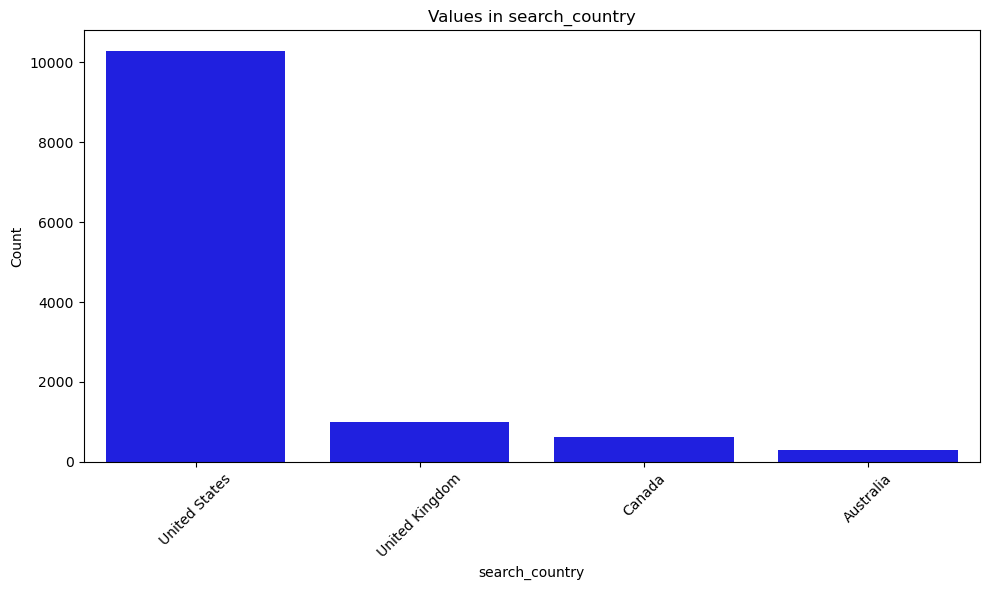

In [16]:
plot_histogram(df, 'search_country')

In [17]:
df_2.describe()

,Job Title,Employment Type,Experience Level,Expertise Level,Salary,Salary Currency,Company Location,Salary in USD,Employee Residence,Company Size
count,600,600,600,600,600,600,600,600,600,600
unique,13,1,3,3,40,4,5,41,4,2
top,Data Engineer,Full-Time,Senior,Expert,172200,United States Dollar,United States,172200,United States,Medium
freq,144,600,528,528,24,528,480,24,480,564


In [18]:
print(df_2['Employee Residence'].value_counts())

Employee Residence
United States     480
United Kingdom     84
Germany            24
India              12
Name: count, dtype: int64


**OBSERVATION 3** Both datasets contain US and UK countries, relevant for the purpose of our analysis, where other countries can be disregarded and removed from the datasets.

### Quality Issue 1: Job Location column of our first data set has a missing value:

In [19]:
#General inspection of the dataframe visually was performed in the steps above

In [20]:
#Job location has one missing value while Inspecting the dataframe programmatically
df.isnull().sum()

job_link               0
last_processed_time    0
last_status            0
got_summary            0
got_ner                0
is_being_worked        0
job_title              0
company                0
job_location           1
first_seen             0
search_city            0
search_country         0
search_position        0
job_level              0
job_type               0
dtype: int64

In [21]:
df[df['job_location'].isnull()]

,job_link,last_processed_time,last_status,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type
9885,https://www.linkedin.com/jobs/view/sr-data-eng...,2024-01-20 04:25:45.213731+00,Finished NER,t,t,f,"Sr. Data Engineer, Abuse Test & Engineering",Tesla,NaN,2024-01-17,Alameda,United States,Test Engineer Mechanical Equipment,Mid senior,Onsite


Issue and justification: *Job Location column has one missing value* based on the inspecting data using isnull method. We used this method as it will be time-consuming and error prone to inspect a full dataset for missing values manually.

### Quality Issue 2: 
Columns referring to Job/Expertise level in both datasets although similar in terms of the distribution (junior to mid allocation) were not filled using exactly the same naming convention. Our assumption is that those levels in each dataset are similar from the definition standpoint, but need to be aligned in regards to naming.

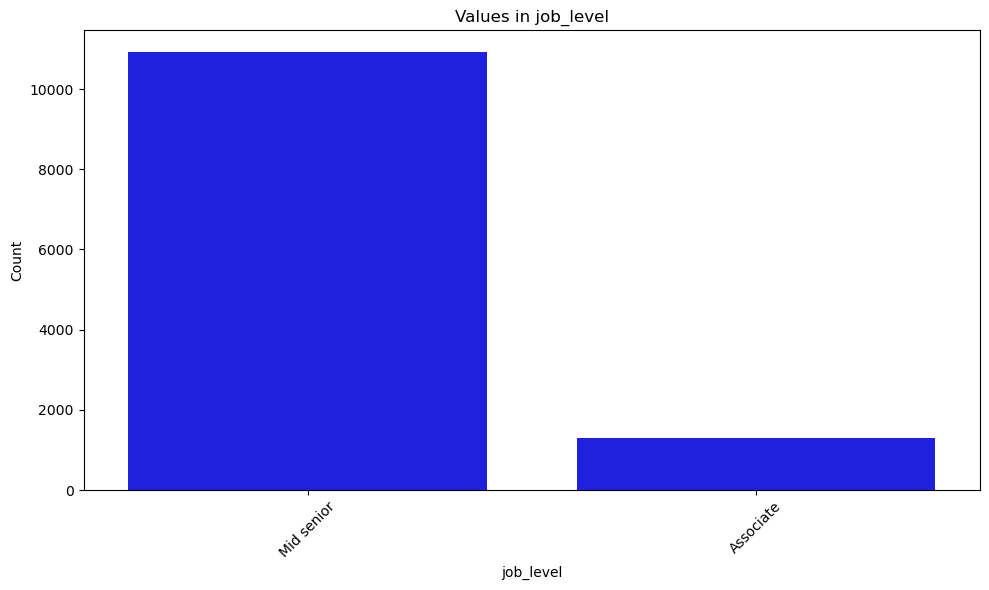

In [22]:
#Histogram for Job level in the 1st dataset - Inspecting the dataframe visually
plot_histogram(df, 'job_level')

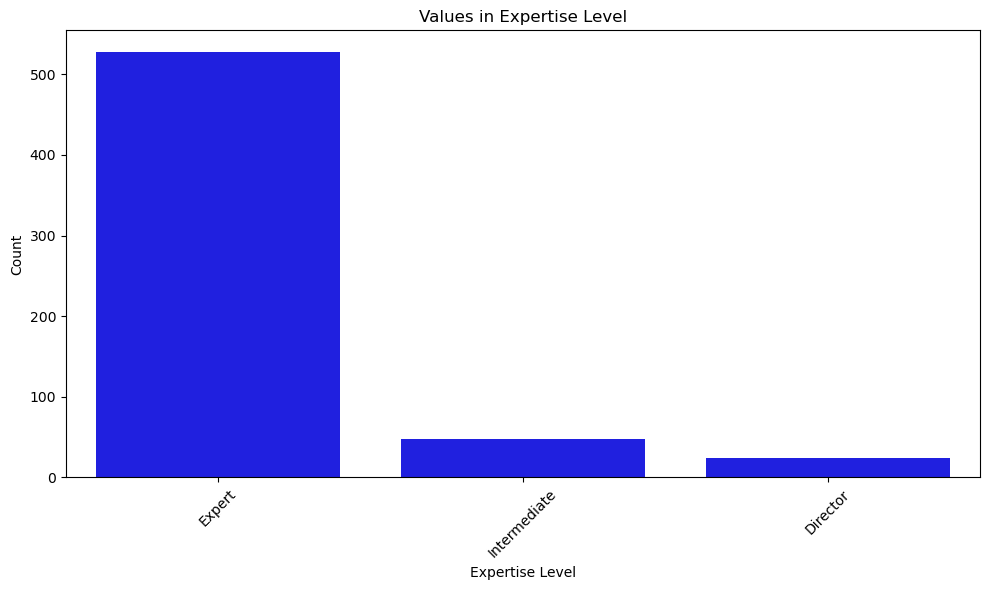

In [23]:
plot_histogram(df_2, 'Expertise Level')

In [24]:
# Inspecting the dataframe programmatically
print(df['job_level'].value_counts())

job_level
Mid senior    10919
Associate      1298
Name: count, dtype: int64


In [25]:
print(df_2['Expertise Level'].value_counts())

Expertise Level
Expert          528
Intermediate     48
Director         24
Name: count, dtype: int64


**Issue and justification**: For the purpose of this analysis we need to combine both datasets based on the job level of data scientists. While Job/Expertise level columns have similar levels, naming convention is different. Our assumption is that these columns should be aligned to ensure consolidation and they have similar terminology behind those categories. We have used Histogram and counting value of each level to identify existing levels in both datasets. This helped us to see visually and programmatically number of categories and the distribution.

### Tidiness Issue 1: Incorrect data types in both datasets

In [26]:
#Inspecting the dataframe visually
df.head()

,job_link,last_processed_time,last_status,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type
0,https://www.linkedin.com/jobs/view/senior-mach...,2024-01-21 08:08:48.031964+00,Finished NER,t,t,f,Senior Machine Learning Engineer,Jobs for Humanity,"New Haven, CT",2024-01-14,East Haven,United States,Agricultural-Research Engineer,Mid senior,Onsite
1,https://www.linkedin.com/jobs/view/principal-s...,2024-01-20 04:02:12.331406+00,Finished NER,t,t,f,"Principal Software Engineer, ML Accelerators",Aurora,"San Francisco, CA",2024-01-14,El Cerrito,United States,Set-Key Driver,Mid senior,Onsite
2,https://www.linkedin.com/jobs/view/senior-etl-...,2024-01-21 08:08:31.941595+00,Finished NER,t,t,f,Senior ETL Data Warehouse Specialist,Adame Services LLC,"New York, NY",2024-01-14,Middletown,United States,Technical Support Specialist,Associate,Onsite
3,https://www.linkedin.com/jobs/view/senior-data...,2024-01-20 15:30:55.796572+00,Finished NER,t,t,f,Senior Data Warehouse Developer / Architect,Morph Enterprise,"Harrisburg, PA",2024-01-12,Lebanon,United States,Architect,Mid senior,Onsite
4,https://www.linkedin.com/jobs/view/lead-data-e...,2024-01-21 08:08:58.312124+00,Finished NER,t,t,f,Lead Data Engineer,Dice,"Plano, TX",2024-01-14,McKinney,United States,Maintenance Data Analyst,Mid senior,Onsite


In [27]:
df_2.head()

,Job Title,Employment Type,Experience Level,Expertise Level,Salary,Salary Currency,Company Location,Salary in USD,Employee Residence,Company Size
0,Data Engineer,Full-Time,Senior,Expert,210000,United States Dollar,United States,210000,United States,Medium
1,Data Engineer,Full-Time,Senior,Expert,165000,United States Dollar,United States,165000,United States,Medium
2,Data Engineer,Full-Time,Senior,Expert,185900,United States Dollar,United States,185900,United States,Medium
3,Data Engineer,Full-Time,Senior,Expert,129300,United States Dollar,United States,129300,United States,Medium
4,Data Scientist,Full-Time,Senior,Expert,140000,United States Dollar,United States,140000,United States,Medium


In [28]:
#Inspecting the dataframe programmatically
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12217 entries, 0 to 12216
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_link             12217 non-null  object
 1   last_processed_time  12217 non-null  object
 2   last_status          12217 non-null  object
 3   got_summary          12217 non-null  object
 4   got_ner              12217 non-null  object
 5   is_being_worked      12217 non-null  object
 6   job_title            12217 non-null  object
 7   company              12217 non-null  object
 8   job_location         12216 non-null  object
 9   first_seen           12217 non-null  object
 10  search_city          12217 non-null  object
 11  search_country       12217 non-null  object
 12  search_position      12217 non-null  object
 13  job_level            12217 non-null  object
 14  job_type             12217 non-null  object
dtypes: object(15)
memory usage: 1.4+ MB


In [29]:
# to analyse values in last_processed_time
print(df['last_processed_time'].str.slice(0, 10).value_counts())

last_processed_time
2024-01-19    8235
2024-01-20    2186
2024-01-21    1796
Name: count, dtype: int64


In [30]:
# to analyse values in first_seen column
df['first_seen'].value_counts()

first_seen
2024-01-13    4946
2024-01-14    3194
2024-01-12    1722
2024-01-16    1211
2024-01-15     871
2024-01-17     273
Name: count, dtype: int64

In [31]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Job Title           600 non-null    object
 1   Employment Type     600 non-null    object
 2   Experience Level    600 non-null    object
 3   Expertise Level     600 non-null    object
 4   Salary              600 non-null    object
 5   Salary Currency     600 non-null    object
 6   Company Location    600 non-null    object
 7   Salary in USD       600 non-null    object
 8   Employee Residence  600 non-null    object
 9   Company Size        600 non-null    object
dtypes: object(10)
memory usage: 47.0+ KB


Issue and justification: *Incorrect data types* for both datasets. 

First dataset contains: last_processed_time and first_seen, which after the visual inspection have date time and date values respectively, but have object data types according to a programatical inspection.

Second dataset contains Salary and Salary in USD columns. Both columns have object data type and for that reason cannot be used for deriving average salaries and other statistics, required for our analysis. We used visual inspection of the data, combining information about data types programmatically to identify incorrect data types used. According to the visual inspection, we see numerical values in Salary and Salary in USD columns, while they have an object data type as per programmatical inspection.

### Tidiness Issue 2: Job Location column contains City and State/Country information in one column

In [32]:
# Inspecting the dataframe visually, using random sample of rows to view job_location column contents in relation to country column
print(df[['job_location', 'search_country']].sample(n=5, random_state=502))

                         job_location  search_country
3423                      Norfolk, VA   United States
1958         Gatineau, Quebec, Canada          Canada
449                   Kansas City, MO   United States
4744                       McLean, VA   United States
3871  London, England, United Kingdom  United Kingdom


In [33]:
#Inspecting the dataframe programmatically
# Grouping by 'search_city', 'job_location', and 'search_country' for Non-US countries
display(df[df['search_country'] != 'United States'].groupby(['job_location', 'search_city', 'search_country']).size().reset_index(name='count'))

,job_location,search_city,search_country,count
0,"Abbots Salford, England, United Kingdom",Gloucester,United Kingdom,2
1,"Abbotsford, British Columbia, Canada",Langley,Canada,1
2,"Aberdeen, Scotland, United Kingdom",Aberdeen,United Kingdom,7
3,"Adelaide, South Australia, Australia",Redcliffe,Australia,2
4,"Adelaide, South Australia, Australia",South Australia,Australia,3
...,...,...,...,...
566,"Woughton on the Green, England, United Kingdom",Milton Keynes,United Kingdom,1
567,"Wythall, England, United Kingdom",Hastings,United Kingdom,1
568,"Wythall, England, United Kingdom",Worcester,United Kingdom,1
569,"Yellowknife, Northwest Territories, Canada",Yellowknife,Canada,1


In [34]:
# Grouping by 'search_city', 'job_location', and 'search_country' for US countries
display(df[df['search_country'] == 'United States'].groupby(['job_location', 'search_city', 'search_country']).size().reset_index(name='count'))

,job_location,search_city,search_country,count
0,"Abbott, TX",Texas,United States,1
1,"Abbott, TX",Waco,United States,2
2,"Aberdeen Proving Ground, MD",Aberdeen,United States,9
3,"Aberdeen Proving Ground, MD",Maryland,United States,1
4,"Aberdeen, MD",Aberdeen,United States,6
...,...,...,...,...
2958,"Youngstown, OH",Bessemer,United States,2
2959,"Youngstown, OH",Ohio,United States,2
2960,"Yuma, AZ",Andalusia,United States,1
2961,"Zelienople, PA",Pennsylvania,United States,1


Issue and justification: *Job location column contains combination of City and state for US and Country for non-US areas*. This column has inconsistency issue and contains two values in one column, complicating further analysis. We have used visual and programmatical ways to analyse and understand values of this column. Additionally, we used group By statements to see job_location field in combination with search_country and search_city columns to identify the logic of job_location field. 

## 3. Clean data
Clean the data to solve the 4 issues corresponding to data quality and tidiness found in the assessing step. **Make sure you include justifications for your cleaning decisions.**

After the cleaning for each issue, please use **either** the visually or programmatical method to validate the cleaning was successful.

At this stage, you are also expected to remove variables that are unnecessary for your analysis and combine your datasets. Depending on your datasets, you may choose to perform variable combination and elimination before or after the cleaning stage. Your dataset must have **at least** 4 variables after combining the data.

In [35]:
# Creating copies of the original files before implementation of the cleaning steps, additionally we stored raw data in csv files above.
df_cleaned1=df.copy()
df_cleaned2=df_2.copy()

### **Quality Issue 1: Job Location column of our first data set has a missing value**

After observing a missing line below, we see that job_location is NaN, while search_city is Alameda, search_country is United States and company is Tesla.

In [36]:
df[df['job_location'].isnull()]

,job_link,last_processed_time,last_status,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type
9885,https://www.linkedin.com/jobs/view/sr-data-eng...,2024-01-20 04:25:45.213731+00,Finished NER,t,t,f,"Sr. Data Engineer, Abuse Test & Engineering",Tesla,NaN,2024-01-17,Alameda,United States,Test Engineer Mechanical Equipment,Mid senior,Onsite


Step 1. We will try to see whether there are any other similar lines in the database, which contain exactly the same parameters, as above and whether we can duplicate value from those similar lines

In [37]:
df[(df['search_city'] == 'Alameda') & (df['company'] == 'Tesla')]

,job_link,last_processed_time,last_status,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type
8559,https://www.linkedin.com/jobs/view/sr-ml-infra...,2024-01-20 05:43:48.539384+00,Finished NER,t,t,f,"Sr. ML Infrastructure Software Engineer, Autop...",Tesla,"Palo Alto, CA",2024-01-16,Alameda,United States,Loading-Machine Tool-Setter,Mid senior,Onsite
9885,https://www.linkedin.com/jobs/view/sr-data-eng...,2024-01-20 04:25:45.213731+00,Finished NER,t,t,f,"Sr. Data Engineer, Abuse Test & Engineering",Tesla,NaN,2024-01-17,Alameda,United States,Test Engineer Mechanical Equipment,Mid senior,Onsite
10872,https://www.linkedin.com/jobs/view/staff-data-...,2024-01-20 13:32:04.81263+00,Finished NER,t,t,f,"Staff Data Engineer, Quality Data Analytics & ...",Tesla,"Fremont, CA",2024-01-14,Alameda,United States,Computer Operator,Mid senior,Onsite


From the above analysis, we see that for the same Company, search_city and search_country there could be different values for job_location. For that reason we will avoid filling-in this row with any value. 

As we have only one line with a missing value and there will be a minimal statistical effect of this line on any conclusions derived, we have decided to clean the data via removing this line completely.

In [38]:
# Dropping a row with a missing value
df_cleaned1=df.dropna()

In [39]:
# Quality issue 1 check after cleaning - Validate the cleaning was successful
df_cleaned1.isnull().sum()

job_link               0
last_processed_time    0
last_status            0
got_summary            0
got_ner                0
is_being_worked        0
job_title              0
company                0
job_location           0
first_seen             0
search_city            0
search_country         0
search_position        0
job_level              0
job_type               0
dtype: int64

In [40]:
# Checking the total number of rows, which should be less that raw data for 1 entry only
df_cleaned1['job_location'].info()

<class 'pandas.core.series.Series'>
Index: 12216 entries, 0 to 12216
Series name: job_location
Non-Null Count  Dtype 
--------------  ----- 
12216 non-null  object
dtypes: object(1)
memory usage: 190.9+ KB


Justification: *As filling-in the missing line with a correct value, derived from other columns was not feasible and also considering that we have only 1 missing entry (with limited impact on an overall dataset), we have decided to clean the dataset by removing the missing value.*

### **Quality Issue 2: Columns referring to Job/Expertise level in both datasets although similar in terms of the distribution (junior to mid allocation) were not filled using exactly the same naming convention. Our assumption is that those levels in each dataset are similar from the definition standpoint, but need to be aligned in regards to naming.**

Justification: *We have decided to align both datasets in regards to the naming convention via introducing a new column in the second data set (with the same name as in the first dataset: job_level), where Intermediate category will be categorized as Associate and Expert: Mid Senior.*

In [41]:
# Create a new column 'Job Level' based on conditions from 'Expertise Level'
df_cleaned2['job_level'] = np.where(df_cleaned2['Expertise Level'] == 'Intermediate', 'Associate',
                     np.where(df_cleaned2['Expertise Level'] == 'Expert', 'Mid senior', df_cleaned2['Expertise Level']))

In [42]:
# Display the updated DataFrame to verify the changes
print(df_cleaned2[['Expertise Level', 'job_level']].value_counts())

Expertise Level  job_level 
Expert           Mid senior    528
Intermediate     Associate      48
Director         Director       24
Name: count, dtype: int64


In [43]:
# Display of the first dataset checking for comparability purposes
print(df_cleaned1['job_level'].value_counts())

job_level
Mid senior    10918
Associate      1298
Name: count, dtype: int64


### **Tidiness Issue 1: Incorrect data types in both datasets**

In [44]:
# Convert 'last_processed_time' to datetime using .loc
df_cleaned1.loc[:, 'last_processed_time'] = pd.to_datetime(df_cleaned1['last_processed_time'], errors='coerce')

# Convert 'first_seen' to datetime using .loc
df_cleaned1.loc[:, 'first_seen'] = pd.to_datetime(df_cleaned1['first_seen'], errors='coerce')

In [45]:
# Display the updated DataFrame to verify the changes
print(df_cleaned1[['last_processed_time', 'first_seen']])

                    last_processed_time           first_seen
0      2024-01-21 08:08:48.031964+00:00  2024-01-14 00:00:00
1      2024-01-20 04:02:12.331406+00:00  2024-01-14 00:00:00
2      2024-01-21 08:08:31.941595+00:00  2024-01-14 00:00:00
3      2024-01-20 15:30:55.796572+00:00  2024-01-12 00:00:00
4      2024-01-21 08:08:58.312124+00:00  2024-01-14 00:00:00
...                                 ...                  ...
12212  2024-01-21 07:11:22.099082+00:00  2024-01-16 00:00:00
12213  2024-01-19 15:10:41.177008+00:00  2024-01-14 00:00:00
12214  2024-01-20 15:20:19.036168+00:00  2024-01-16 00:00:00
12215  2024-01-19 23:25:28.107523+00:00  2024-01-16 00:00:00
12216  2024-01-19 23:26:27.593516+00:00  2024-01-14 00:00:00

[12216 rows x 2 columns]


In [46]:
df_cleaned1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12216 entries, 0 to 12216
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_link             12216 non-null  object
 1   last_processed_time  12216 non-null  object
 2   last_status          12216 non-null  object
 3   got_summary          12216 non-null  object
 4   got_ner              12216 non-null  object
 5   is_being_worked      12216 non-null  object
 6   job_title            12216 non-null  object
 7   company              12216 non-null  object
 8   job_location         12216 non-null  object
 9   first_seen           12216 non-null  object
 10  search_city          12216 non-null  object
 11  search_country       12216 non-null  object
 12  search_position      12216 non-null  object
 13  job_level            12216 non-null  object
 14  job_type             12216 non-null  object
dtypes: object(15)
memory usage: 1.5+ MB


In [47]:
# Convert 'Salary' to float
df_cleaned2['Salary'] = pd.to_numeric(df_cleaned2['Salary'], errors='coerce')

# Convert 'Salary in USD' to float
df_cleaned2['Salary in USD'] = pd.to_numeric(df_cleaned2['Salary in USD'], errors='coerce')

In [48]:
df_cleaned2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Job Title           600 non-null    object
 1   Employment Type     600 non-null    object
 2   Experience Level    600 non-null    object
 3   Expertise Level     600 non-null    object
 4   Salary              600 non-null    int64 
 5   Salary Currency     600 non-null    object
 6   Company Location    600 non-null    object
 7   Salary in USD       600 non-null    int64 
 8   Employee Residence  600 non-null    object
 9   Company Size        600 non-null    object
 10  job_level           600 non-null    object
dtypes: int64(2), object(9)
memory usage: 51.7+ KB


Justification: *We have corrected incorrect data types to be able to use those columns correctly, including deriving average values from Salary column. Data now is displayed correctly using describe method as well as in a box plot below for the second dataset*

In [49]:
df_cleaned2.describe()

,Salary,Salary in USD
count,6.000000e+02,600.000000
mean,1.928829e+05,154579.220000
std,2.644021e+05,57571.927618
min,5.000000e+04,24322.000000
25%,1.197000e+05,118800.000000
50%,1.475000e+05,143600.000000
75%,1.859000e+05,185900.000000
max,2.000000e+06,323300.000000


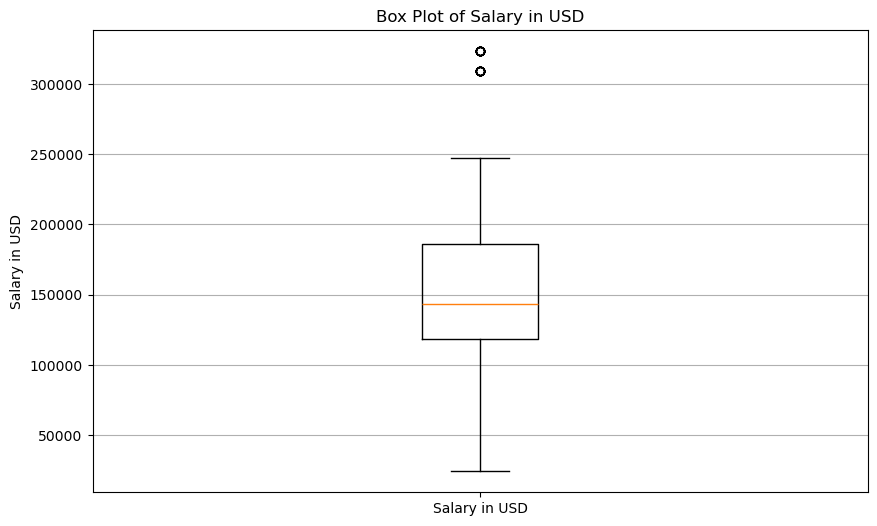

In [50]:
# Create a box plot for the 'Salary in USD' column
plt.figure(figsize=(10, 6))  # Set the figure size
plt.boxplot(df_cleaned2['Salary in USD'].dropna())
plt.title('Box Plot of Salary in USD')
plt.ylabel('Salary in USD')
plt.xticks([1], ['Salary in USD'])
plt.grid(axis='y')
plt.show()

### **Tidiness Issue 2: Job Location column contains City and State/Country information in one column**

In [51]:
# Split the 'job_location' column into separate columns
location_split = df_cleaned1['job_location'].str.split(', ', expand=True)

# Rename the new columns for clarity
location_split.columns = ['City', 'Region', 'Country2']

# Combine the new columns with the original DataFrame
df_cleaned1_location = pd.concat([df_cleaned1, location_split], axis=1)

In [52]:
# For United States and for some other lines, job_location column doesn't have an indication of a country at all, thus we have created a new logic,
# when 'Country2' column is missing, then we should use search_country otherwise Country2
df_cleaned1_location['Country'] = np.where(
    (df_cleaned1_location['Country2'].isnull() | (df_cleaned1_location['Country2'] == '')),
    df_cleaned1_location['search_country'],
    df_cleaned1_location['Country2']
)

In [53]:
df_cleaned1_location = df_cleaned1_location.drop(columns=['Country2'])

In [54]:
df_cleaned1_location.head()

,job_link,last_processed_time,last_status,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type,City,Region,Country
0,https://www.linkedin.com/jobs/view/senior-mach...,2024-01-21 08:08:48.031964+00:00,Finished NER,t,t,f,Senior Machine Learning Engineer,Jobs for Humanity,"New Haven, CT",2024-01-14 00:00:00,East Haven,United States,Agricultural-Research Engineer,Mid senior,Onsite,New Haven,CT,United States
1,https://www.linkedin.com/jobs/view/principal-s...,2024-01-20 04:02:12.331406+00:00,Finished NER,t,t,f,"Principal Software Engineer, ML Accelerators",Aurora,"San Francisco, CA",2024-01-14 00:00:00,El Cerrito,United States,Set-Key Driver,Mid senior,Onsite,San Francisco,CA,United States
2,https://www.linkedin.com/jobs/view/senior-etl-...,2024-01-21 08:08:31.941595+00:00,Finished NER,t,t,f,Senior ETL Data Warehouse Specialist,Adame Services LLC,"New York, NY",2024-01-14 00:00:00,Middletown,United States,Technical Support Specialist,Associate,Onsite,New York,NY,United States
3,https://www.linkedin.com/jobs/view/senior-data...,2024-01-20 15:30:55.796572+00:00,Finished NER,t,t,f,Senior Data Warehouse Developer / Architect,Morph Enterprise,"Harrisburg, PA",2024-01-12 00:00:00,Lebanon,United States,Architect,Mid senior,Onsite,Harrisburg,PA,United States
4,https://www.linkedin.com/jobs/view/lead-data-e...,2024-01-21 08:08:58.312124+00:00,Finished NER,t,t,f,Lead Data Engineer,Dice,"Plano, TX",2024-01-14 00:00:00,McKinney,United States,Maintenance Data Analyst,Mid senior,Onsite,Plano,TX,United States


In [55]:
# Checking data for Non-US countries
# Grouping by 'search_city', 'job_location', and 'search_country' for Non-US countries
display(df_cleaned1_location[df_cleaned1_location['Country'] != 'United States'].groupby(['job_location', 'City', 'Region','Country']).size().reset_index(name='count'))

,job_location,City,Region,Country,count
0,"Abbots Salford, England, United Kingdom",Abbots Salford,England,United Kingdom,2
1,"Abbotsford, British Columbia, Canada",Abbotsford,British Columbia,Canada,1
2,"Aberdeen, Scotland, United Kingdom",Aberdeen,Scotland,United Kingdom,7
3,"Adelaide, South Australia, Australia",Adelaide,South Australia,Australia,5
4,"Alberta, Canada",Alberta,Canada,Canada,2
...,...,...,...,...,...
414,"Worthing, England, United Kingdom",Worthing,England,United Kingdom,1
415,"Woughton on the Green, England, United Kingdom",Woughton on the Green,England,United Kingdom,1
416,"Wythall, England, United Kingdom",Wythall,England,United Kingdom,2
417,"Yellowknife, Northwest Territories, Canada",Yellowknife,Northwest Territories,Canada,1


In [56]:
# Checking data for United States
# Grouping by 'search_city', 'job_location', and 'search_country' for US countries
display(df_cleaned1_location[df_cleaned1_location['Country'] == 'United States'].groupby(['job_location', 'City', 'Region','Country']).size().reset_index(name='count'))

,job_location,City,Region,Country,count
0,"Abbott, TX",Abbott,TX,United States,3
1,"Aberdeen Proving Ground, MD",Aberdeen Proving Ground,MD,United States,10
2,"Aberdeen, MD",Aberdeen,MD,United States,6
3,"Abington, MA",Abington,MA,United States,1
4,"Acoma Pueblo, NM",Acoma Pueblo,NM,United States,1
...,...,...,...,...,...
1576,"Yorkville, IL",Yorkville,IL,United States,1
1577,"Youngstown, OH",Youngstown,OH,United States,4
1578,"Yuma, AZ",Yuma,AZ,United States,1
1579,"Zelienople, PA",Zelienople,PA,United States,1


In [57]:
# Checking for missing values
df_cleaned1_location.isnull().sum()

job_link                 0
last_processed_time      0
last_status              0
got_summary              0
got_ner                  0
is_being_worked          0
job_title                0
company                  0
job_location             0
first_seen               0
search_city              0
search_country           0
search_position          0
job_level                0
job_type                 0
City                     0
Region                 295
Country                  0
dtype: int64

Justification: *Using a combination of job_location and search_country columns, we have separated City and Country columns taken from job_location.* The method used ensured absence of missing values in City and Country columns, where the latter one will be used in our combined dataset analysis.

**LIMITATION** Region column is assumed to be not relevant for our analysis and have a lower importance overall. For that reason further clean up data was not proceeded to fill-in missing values in the Region column.

In [58]:
# after validation of job_location column logic, we use it for further steps
df_cleaned1=df_cleaned1_location

### **Removing unnecessary variables and combining datasets**

Following the **OBSERVATION 2** above, the first dataset contains last_status and is_being_worked columns, which contain only one value and can be removed from the analysis due to absence of any additional information and add value.

We have decided to use only the relevant information from both datasets and combine only aggregated values in the resulting combined dataframe. So that our stakeholders would be able to see the final concise table as a result.

Below is an extraction of only relevant information for our further analysis from the first dataframe.
This step includes the following:
- filtering for US and UK countries
- selecting relevant Country and Job level fields
- calculating count of rows and aggregating the dataset, to be able to compare the market size of both countries in terms of available open positions

In [59]:
df_1_agg=df_cleaned1[
        (df_cleaned1['Country'].isin(['United States', 'United Kingdom']))
    ].groupby(['Country','job_level']).size().reset_index(name='count')
df_1_agg

,Country,job_level,count
0,United Kingdom,Associate,115
1,United Kingdom,Mid senior,880
2,United States,Associate,1108
3,United States,Mid senior,9163


Below is an extraction of only relevant information for our further analysis from the second dataframe.
This step includes the following:
- filtering for US and UK countries
- selecting relevant Country and Job level fields
- calculating relevant statistics for Salary in USD for aggregated dataset, to be able to combine this information with the open positions / market size in both countries

In [60]:
# Filter the DataFrame for 'United States' and 'United Kingdom'
df_2_filtered = df_cleaned2[(df_cleaned2['Employee Residence'].isin(['United States', 'United Kingdom']))]

# Group by 'Employee Residence' and 'job_level', and calculate various statistics
df_2_agg = df_2_filtered.groupby(['Employee Residence', 'job_level']).agg(
    Average_Salary=('Salary in USD', 'mean'),
    Max_Salary=('Salary in USD', 'max'),
    Min_Salary=('Salary in USD', 'min'),
    Mode_Salary=('Salary in USD', lambda x: x.mode().iloc[0] if not x.mode().empty else None),
    Q1=('Salary in USD', lambda x: x.quantile(0.25)),
    Q3=('Salary in USD', lambda x: x.quantile(0.75)),
    Std_Dev=('Salary in USD', 'std')
).reset_index()

# Display the resulting DataFrame
df_2_agg

,Employee Residence,job_level,Average_Salary,Max_Salary,Min_Salary,Mode_Salary,Q1,Q3,Std_Dev
0,United Kingdom,Associate,86128.000000,104584,61520,61520,61520.0,104584.0,18367.904032
1,United Kingdom,Mid senior,144411.000000,180514,108308,108308,108308.0,180514.0,36485.052968
2,United States,Director,209850.000000,247500,172200,172200,172200.0,247500.0,38459.770060
3,United States,Mid senior,165389.473684,323300,75000,129300,130000.0,193600.0,52340.305514


In [61]:
# Rename columns in df_2 to perform merging
df_2_agg = df_2_agg.rename(columns={'Employee Residence': 'Country'})

# Merge the two DataFrames on 'search_country' and 'job_level'
df_combined = pd.merge(df_1_agg, df_2_agg, on=['Country', 'job_level'], how='outer')

# Display the combined DataFrame
df_combined

,Country,job_level,count,Average_Salary,Max_Salary,Min_Salary,Mode_Salary,Q1,Q3,Std_Dev
0,United Kingdom,Associate,115.0,86128.000000,104584.0,61520.0,61520.0,61520.0,104584.0,18367.904032
1,United Kingdom,Mid senior,880.0,144411.000000,180514.0,108308.0,108308.0,108308.0,180514.0,36485.052968
2,United States,Associate,1108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,United States,Director,NaN,209850.000000,247500.0,172200.0,172200.0,172200.0,247500.0,38459.770060
4,United States,Mid senior,9163.0,165389.473684,323300.0,75000.0,129300.0,130000.0,193600.0,52340.305514


## 4. Updating data store
We have stored raw data, cleaned and processed data as well as the resulting combined table in separate csv files below:

In [62]:
#Raw data was previously stored in csvs as following:
# 'raw_data1.csv'
# 'raw_data2.csv'

In [63]:
# Storing processed and cleaned versions of each dataset:
df_cleaned1.to_csv('cleaned_data1.csv', index=False)
df_cleaned2.to_csv('cleaned_data2.csv', index=False)

In [64]:
# Storing the final output of our analysis:
df_combined.to_csv('result_combined.csv', index=False)

## 5. Answer the research question

### **5.1:** Define and answer the research question 
Going back to the problem statement in step 1, use the cleaned data to answer the question you raised. Produce **at least** two visualizations using the cleaned data and explain how they help you answer the question.

*Research question:* What are the major characteristics of US and UK job markets for data science professionals in Mid-senior level?
Specifically:
- how many open positions are available in both countries based on the available data sources;
- what are the Average Salary, Standard deviation, Mode, Minimum and Maximum Salaries of UK and US
- how different Average Salaries are for Mid-senior level Data Science professionals between mentioned countries during the observed period.

Visualizing pie-chart for job market in US and UK per job level below, where we can see that roughly Mid-Senior and Associate levels have similar distribution in each country 

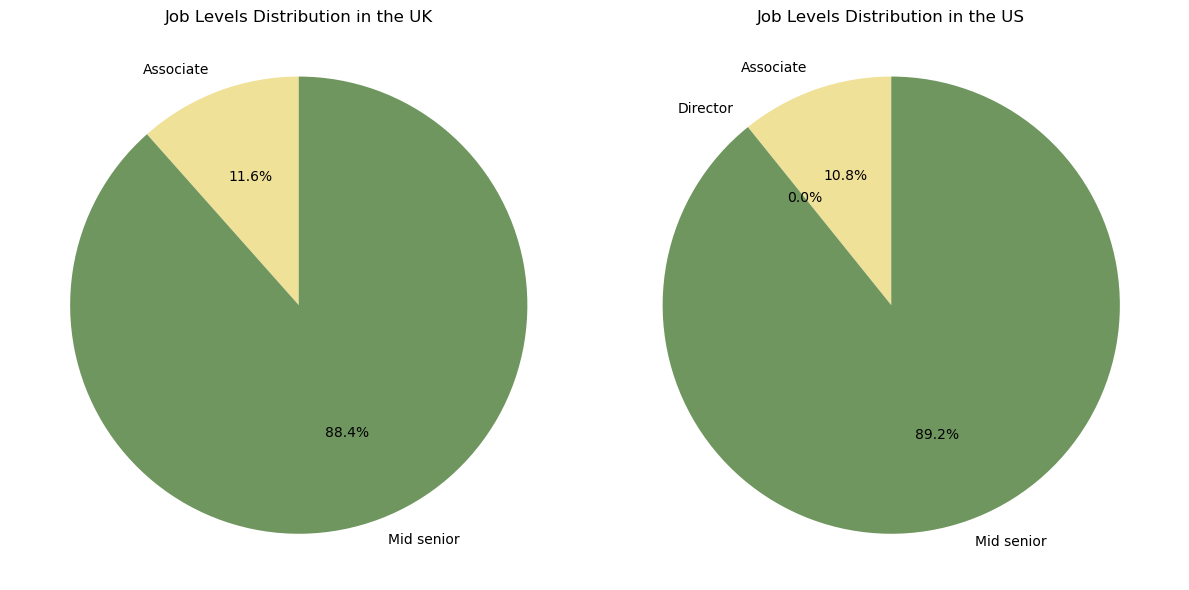

In [66]:
# Define color mapping
color_mapping = {
    'Mid senior': '#6F965F',
    'Associate': '#F0E199',
    'Director': 'red'
}

# Group by job_level and sum the countuk_counts = df_combined[df_combined['Country'] == "United Kingdom"].groupby('job_level')['count'].sum()
us_counts = df_combined[df_combined['Country'] == "United States"].groupby('job_level')['count'].sum()
uk_counts = df_combined[df_combined['Country'] == "United Kingdom"].groupby('job_level')['count'].sum()

# Create pie charts
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# UK Pie Chart
axs[0].pie(uk_counts, labels=uk_counts.index, autopct='%1.1f%%', startangle=90, colors=[color_mapping.get(level, 'grey') for level in uk_counts.index])
axs[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axs[0].set_title('Job Levels Distribution in the UK')

# US Pie Chart
axs[1].pie(us_counts, labels=us_counts.index, autopct='%1.1f%%', startangle=90, colors=[color_mapping.get(level, 'grey') for level in us_counts.index])
axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axs[1].set_title('Job Levels Distribution in the US')

# Show the plots
plt.tight_layout()
plt.show()

In the bubble chart below we see the comparative sizes of US and UK markets represented as bubble size per job levels and visualizing in combination with information about Average Salary. This chart helps us to depict market size and Average Salary superiority of US market compared to UK.

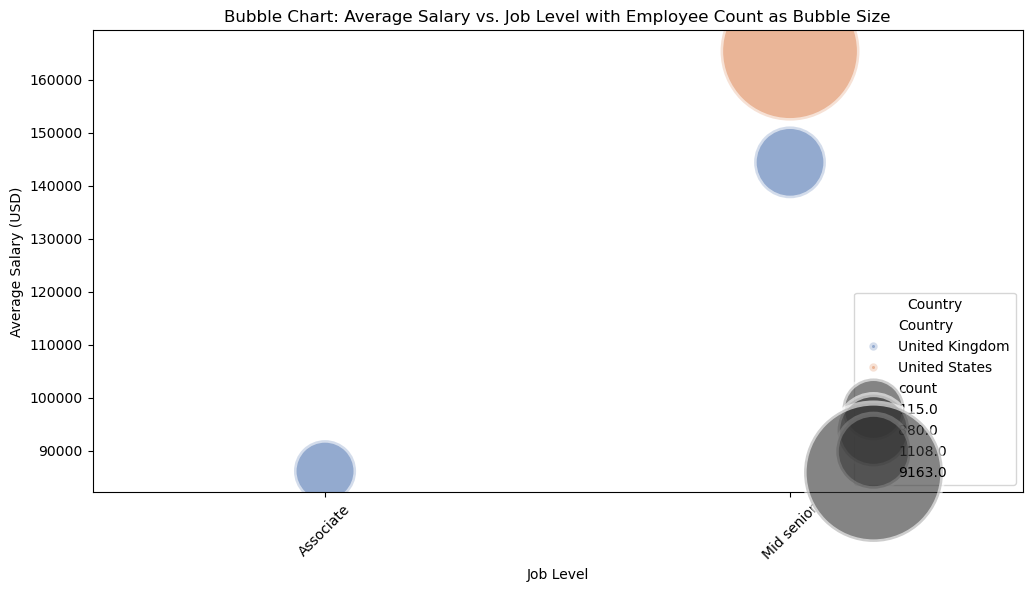

In [67]:
# Create a bubble chart
plt.figure(figsize=(12, 6))
bubble_chart = sns.scatterplot(
    data=df_combined, 
    x='job_level', 
    y='Average_Salary', 
    size='count', 
    sizes=(2000, 10000),  # Adjust the size range of the bubbles
    hue='Country', 
    alpha=0.6, 
    palette='deep'
)

# Set x-axis limits
plt.xlim(-0.5, 1.5)  # Adjust these values based on your job level categories

# Title and labels
plt.title('Bubble Chart: Average Salary vs. Job Level with Employee Count as Bubble Size')
plt.xlabel('Job Level')
plt.ylabel('Average Salary (USD)')
plt.xticks(rotation=45)

# Show legend
plt.legend(title='Country', loc='lower right')

# Show the plot
plt.show()

In [68]:
# Major characteristics of US and UK job market for data science professionals in Mid-senior level are presented below:
df_combined[df_combined['job_level']=='Mid senior']

,Country,job_level,count,Average_Salary,Max_Salary,Min_Salary,Mode_Salary,Q1,Q3,Std_Dev
1,United Kingdom,Mid senior,880.0,144411.000000,180514.0,108308.0,108308.0,108308.0,180514.0,36485.052968
4,United States,Mid senior,9163.0,165389.473684,323300.0,75000.0,129300.0,130000.0,193600.0,52340.305514


*Answer to research question:* 

Job market in US is obviously bigger than UK for data science professionals. However at the same time, we see a similar distribution of open positions between job levels (Mid Senior vs Associate). 

Salaries in terms of USD are higher in US than in UK (including Average and Maximum Salary), while having lower minimum salary compared to UK and higher Standard deviation. One could assume that although US brings higher earning opportunities in general (excluding cost of living effects), UK market offers stable income for data science professionals of different levels with limited growth potential.

In the below bar chart we see the distribution of Average Salaries per job level and countries, which is assisting us to answer the research question.

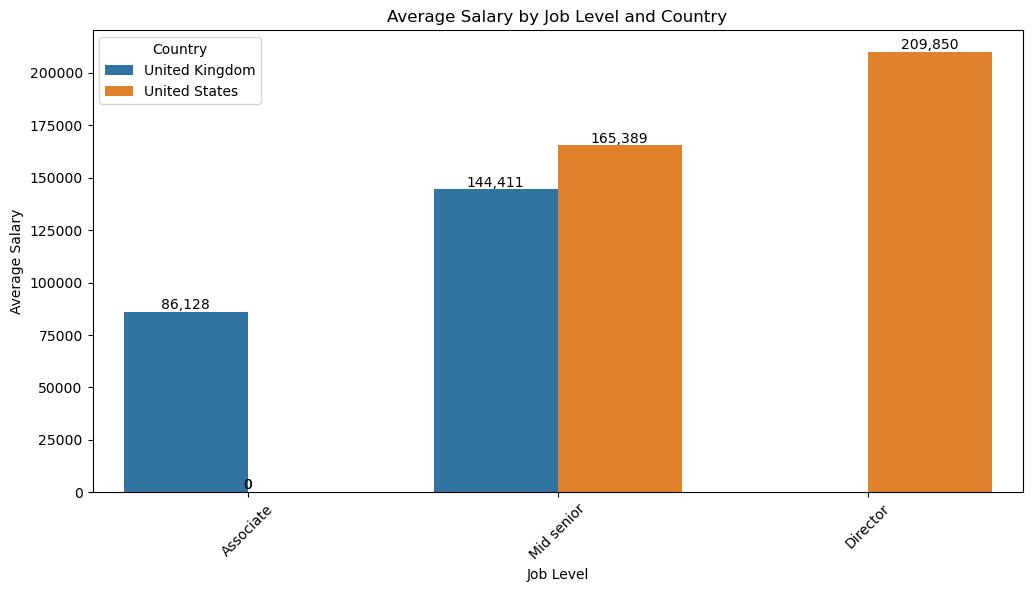

In [69]:
# Create the bar plot
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=df_combined, x='job_level', y='Average_Salary', hue='Country')

# Add value annotations on top of the bars
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height():,.0f}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', 
                      va='bottom', 
                      fontsize=10, 
                      color='black', 
                      xytext=(0, 0),  # Offset the text slightly above the bar
                      textcoords='offset points')

# Title and labels
plt.title('Average Salary by Job Level and Country')
plt.ylabel('Average Salary')
plt.xlabel('Job Level')
plt.legend(title='Country')
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [70]:
average_salary_US = df_combined[
        (df_combined['Country'] == 'United States') & (df_combined['job_level'] == 'Mid senior')
    ]['Average_Salary'].iloc[0]
average_salary_UK = df_combined[
        (df_combined['Country'] == 'United Kingdom') & (df_combined['job_level'] == 'Mid senior')
    ]['Average_Salary'].iloc[0]
average_salary_diff=average_salary_US-average_salary_UK
average_salary_diff_perc=(average_salary_US-average_salary_UK)/average_salary_UK*100


print(f"The difference in Average salary between US and UK for Data Science professionals in Mid Senior level is ${average_salary_diff:,.2f} or {average_salary_diff_perc:,.2f}%")

The difference in Average salary between US and UK for Data Science professionals in Mid Senior level is $20,978.47 or 14.53%


### **5.2:** Reflection
In 2-4 sentences, if you had more time to complete the project, what actions would you take? For example, which data quality and structural issues would you look into further, and what research questions would you further explore?

*Answer:* In case of an interest in continuation of the analysis presented in this report, we could offer the following extensions:
- increasing geography to more countries of interest;
- combine dataset without an aggregation of data, if it is needed, in order to derive more of lower level data analytics and have an ability to track data at entry level;
- exclude the limit in number of entries, set at the beginning of this report, to ensure a bigger coverage of data (please refer to LIMITATION above).